# Part 1: EDA of the logins
Identify temporal patterns in the provided logins file

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import timedelta

In [2]:
logins = pd.read_json('ultimate_challenge/logins.json')
print(logins.shape)
logins.head()

(93142, 1)


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


- The only data column is the time stamp.
- All 93142 values are non-null.
- All dates are in the first few months of 1970, but keep the year for datetime calcs
- Only about 1% of the login times are non-unique.

Project specs call for putting the logins in 15-min bins.  I'll use pd.cut, which will create about 100 bins per day times about 100 days = 10K bins for 93K entries, or fewer than 10 logins per bin, on avg.

In [5]:
start = min(logins.login_time).normalize()  # to have values that line up with clock hours
end = (max(logins.login_time) + timedelta(days=1)).normalize() # add one day to include all times
print(start, end)

1970-01-01 00:00:00 1970-04-14 00:00:00


In [6]:
times = pd.date_range(start=start, end=end, freq='900S')  # 900 secs == 15 min
len(times)

9889

In [7]:
times[:5]

DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 00:15:00',
               '1970-01-01 00:30:00', '1970-01-01 00:45:00',
               '1970-01-01 01:00:00'],
              dtype='datetime64[ns]', freq='900S')

In [8]:
logins['timebin'] = pd.cut(logins.login_time, times)

In [9]:
logins.head(1)

,login_time,timebin
0,1970-01-01 20:13:18,"(1970-01-01 20:00:00, 1970-01-01 20:15:00]"


In [10]:
# pick one time to identify each bin.  End time should work.
logins['bin_end'] = logins.timebin.apply(lambda t: t.right)
logins.head(1)

,login_time,timebin,bin_end
0,1970-01-01 20:13:18,"(1970-01-01 20:00:00, 1970-01-01 20:15:00]",1970-01-01 20:15:00


In [11]:
dayname_map = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 
               4:'Friday', 5:'Saturday', 6:'Sunday'}

In [12]:
# split apart each login time to be able to group by its elements
logins['int_day'] = logins.bin_end.apply(lambda t: t.weekday())
logins['weekday'] = logins.int_day.apply(lambda t: dayname_map[t])
logins['hour']    = logins.bin_end.apply(lambda t: t.hour)
logins['minute']  = logins.bin_end.apply(lambda t: t.minute)
logins['week']    = logins.bin_end.apply(lambda t: t.week)
logins.head(3)

,login_time,timebin,bin_end,int_day,weekday,hour,minute,week
0,1970-01-01 20:13:18,"(1970-01-01 20:00:00, 1970-01-01 20:15:00]",1970-01-01 20:15:00,3,Thursday,20,15,1
1,1970-01-01 20:16:10,"(1970-01-01 20:15:00, 1970-01-01 20:30:00]",1970-01-01 20:30:00,3,Thursday,20,30,1
2,1970-01-01 20:16:37,"(1970-01-01 20:15:00, 1970-01-01 20:30:00]",1970-01-01 20:30:00,3,Thursday,20,30,1


### How do the logins occur, by time unit?

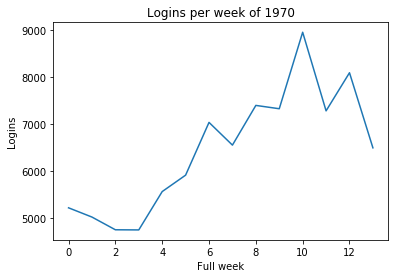

In [13]:
# Start with largest timeframe
plt.plot(logins.groupby('week').size().values[1:-1]) # don't chart the partial first and last weeks
plt.xlabel('Full week')
plt.ylabel('Logins')
plt.title('Logins per week of 1970');

#### Login volume went up from about 5000 per week in January to a peak of 9000/week in mid-March, before decreasing to about 7K/week in April.

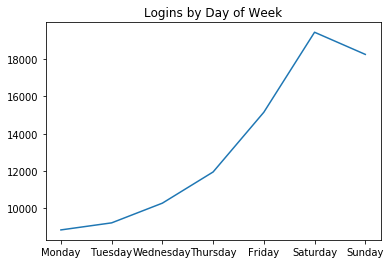

In [14]:
days = logins.groupby('int_day').size()
plt.plot(days)
plt.xticks(range(7), labels=dayname_map.values())
plt.title('Logins by Day of Week');

#### The weekly cycle shows a smooth, maybe quadratic, doubling of volumes from Monday to Saturday, with Sunday almost as high as Sat.

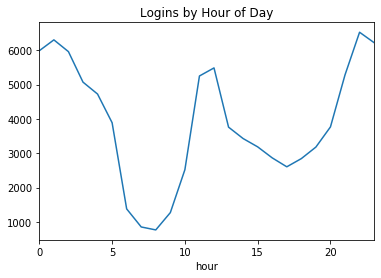

In [15]:
logins.groupby('hour').size().plot()
plt.title('Logins by Hour of Day');

#### Aggregating by hour of day, without regard to day of week, indicates that there are two main peaks of volume, the highest around midnight and the second highest around noon.  From 6am to 9am the logins drop to only 1/6 the midnight levels, and at 5pm there is another lull in traffic, though not as slow as the morning one.

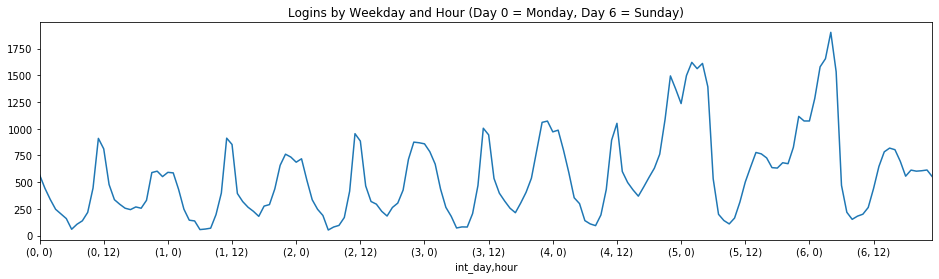

In [16]:
plt.figure(figsize=(16, 4))
grouped = logins.groupby(['int_day', 'hour']).size()
grouped.plot()
# show noon and midnight for each day of week
plt.xticks(ticks=range(0, len(grouped), 12), labels=grouped.index[0::12])
plt.title('Logins by Weekday and Hour (Day 0 = Monday, Day 6 = Sunday)');

#### Add the day of the week to the hour of the day, to see if that changes the hourly pattern at all.   
#### This reveals that there is an extra amount of logins after midnight on Friday and Saturday nights and then also on Saturday and Sunday in the early afternoon.  Without these heavier weekend login periods, the weekdays peak at 11am and 11pm, with the daytime peak actually higher than the nighttime peak.  But the weekend night peaks are large enough to make the overall daily patterns show a higher night peak than day peak (as seen in the previous graph).  The weekend hours between midnight and 4am are the highest-volume period of the week, hiding the fact that during the rest of the week, the busiest night hours are 8pm-midnight.

# Part 2:  Experiment and Metrics Design  


The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

<b>1.  It's unclear from the description what the managers are trying to accomplish with this experiment, and why.  My first thought is that they're trying to have drivers available when needed and where needed, but that doesn't seem to be the case.  To "encourage driver partners to be available in both cities" is to suggest that there's some benefit from each driver splitting her time between cities.  If the benefit comes from driving someone from one city to the other, then there's no experiment needed---The passenger's desired route will dictate the numbers.  If the managers are aiming to balance each driver's individual locations, for some reason, then the natural thing to do would be to try to get the drivers to work shifts that span the night/day or day/night transition.  That way, they could work where most needed at all times, pay the toll just once when the demand location changes, and still fulfill the stated goal of the experiment.  For the weekends, drivers could be encouraged to work different cities on different days or weeks.  But I'll just focus on the free toll initiative (which by itself should increase the number of beneficial inter-city trips, by lowering Ultimate's fares compared to Ultimate's competitors).
    
One metric that makes sense for this experiment is to measure how closely each driver's trip ratio comes to the proportion of all trips that each city accounts for during the trial period.  If Gotham accounted for 65% of the trips during that period, but driver Pat's trips were 60% in Metropolis, then Pat's ratio was off by 25 percentage points. Even if the ratio of all drivers' trips during Pat's shifts lined up exactly with Pat's ratio, the fact that it differed by 25 points from the overall target suggests that Pat should be focusing more on Gotham and less on Metropolis.  So more night shifts for Pat, if possible.
    
To measure this "closeness to the target", for the sake of determining how successful the experiment was, I would suggest using the mean squared error, in this case the average, over all drivers, of the square of how far away each driver's trip ratio was from the overall ratio.  I would also suggest weighting each driver's score according to how many trips he drove during the measured period of time.  I.e. if Pat drove 20 trips with that 25-point "error", while driver Sam drove 40 trips with a 10-point error, and those were the only drivers in the whole company, then the weighted mean squared error measurement would be the mean of Pat's $\frac{20 * 25^2}{60}$ and Sam's $\frac{40 * 10^2}{60}$.  I divided by 60 to normalize for the total number of trips, for a fairer comparison of scores between the experimental periods and the non-experimental ones.<b/>  

<b>2.  ...And that's how I'd propose to set up the experiment:  Compare all drivers for 4 weeks and see how their scores change.  First week no experiment, second week experiment, third week no experiment, fourth week experiment.  Let the drivers know the plan during the first week, to give them time to think about how they might respond to the free tolls.  The measurements from the fourth week could be compared to the second week as an indicator of how drivers are adapting to the change, and as such, weighed more heavily in any conclusions.  Using whole week periods and alternating them twice should keep everything somewhat uniform between the control and experimental periods.
    
The alternative would be to separate drivers into experimental ones and regular ones, where the two groups are working at the same time, and then compare their numbers.  But I don't like that approach as much, since the fares available at any one time in any one city are a limited quantity, and by intentionally altering the behavior of the experimental group, you'd be affecting the control group as well, giving you a less clear picture of the results.  

To gauge how effective free tolls are, I'd calculate the metric (weighted MSE) for every week in the historical data and plot those numbers against time, to be aware of any overall trend, including discarding possible outliers, say for holidays.  If there were some long-term overall trend, I would discard any older data that was not reflective of current conditions (e.g. old regulations or different toll prices might have influenced older numbers in a way that no longer applies).  Assuming the remaining data appeared normally distributed and non-cyclical, I'd state a significance level and then test the null hypothesis that the experiment had not had any effect on the MSE.  Then I'd check how the 2 combined toll-free weeks compared to the other 2 weeks combined, and calculate the same difference for analogous 4-week periods in the past.  Again, hypothesis testing these differences would show how significant the experiment was.  And finally, as mentioned before, I'd look at how the second toll-free week compared to the first one, to analyze how drivers were responding to the free tolls.  

I'd make clear to the city operations team that the experiment was judged by how much closer it brought the drivers' personal Gotham/Metropolis ratios to the combined overall ratio.  Essentially, it measures how similar everyone's ratio is.  The managers may have actually intended to try to bring everyone's ratio to 1-to-1, equal trips in each city, but that's not how the question is posed, and if 75% of the traffic is in Gotham, it doesn't make sense as a target anyway.  There's also the question of how much money this experiment is costing Ultimate, vs. how much reward, if any, they're getting for it. </b>  
   

# Part 3 ‐ Predictive modeling  

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


In [17]:
with open('ultimate_challenge/ultimate_data_challenge.json', 'r') as f:
    data = json.loads(f.read())

In [18]:
len(data)

50000

In [19]:
data[0]

{'city': "King's Landing",
 'trips_in_first_30_days': 4,
 'signup_date': '2014-01-25',
 'avg_rating_of_driver': 4.7,
 'avg_surge': 1.1,
 'last_trip_date': '2014-06-17',
 'phone': 'iPhone',
 'surge_pct': 15.4,
 'ultimate_black_user': True,
 'weekday_pct': 46.2,
 'avg_dist': 3.67,
 'avg_rating_by_driver': 5.0}

In [20]:
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


- Null values occur only in the ratings and in the phone type.
- Dates will need to be converted to datetimes from strings.

In [22]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [23]:
# make a "NONE" phone type, in case that predicts anything
df.phone.fillna('NONE', inplace=True)

In [24]:
# convert date strings to date times
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)
df['signup_date'] = pd.to_datetime(df.signup_date)

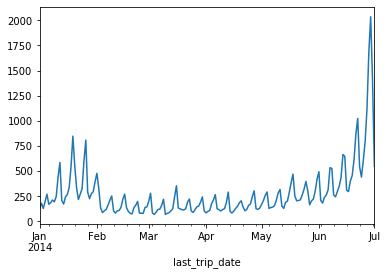

In [25]:
df.groupby('last_trip_date').size().plot();

In [26]:
df['retained'] = df.last_trip_date >= '2014-06-01'
print(f'{round(df.retained.mean() * 100, 2)}% of Users were retained.')

37.61% of Users were retained.


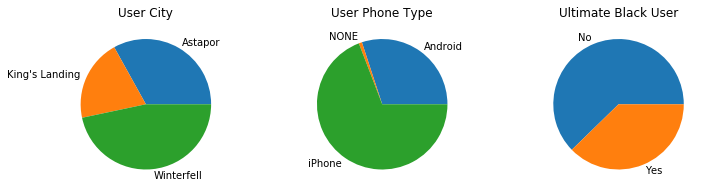

In [27]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
citygroup = df.groupby('city').size()
plt.pie(citygroup, labels=citygroup.keys())
plt.title('User City')
plt.subplot(132)
phonegroup = df.groupby('phone').size()
plt.pie(phonegroup, labels=phonegroup.keys())
plt.title("User Phone Type")
plt.subplot(133)
blackgroup = df.groupby('ultimate_black_user').size()
plt.pie(blackgroup, labels=np.where(blackgroup.keys(), 'Yes', 'No'))
plt.title('Ultimate Black User');

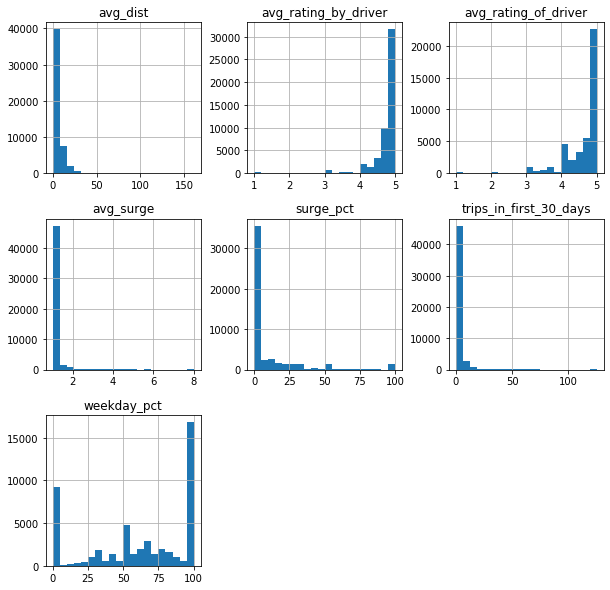

In [28]:
df.hist(column=['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'surge_pct',
       'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'], figsize=(10, 10), bins=20);

In [29]:
df.corr()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
trips_in_first_30_days,1.000000,-0.011302,-0.001841,0.005720,0.112210,0.050388,-0.136329,-0.039115,0.210463
avg_rating_of_driver,-0.011302,1.000000,-0.026189,-0.003899,-0.002086,0.014630,0.034509,0.123175,-0.011653
avg_surge,-0.001841,-0.026189,1.000000,0.793582,-0.078791,-0.110071,-0.081491,0.010597,-0.003333
surge_pct,0.005720,-0.003899,0.793582,1.000000,-0.106861,-0.144918,-0.104414,0.020103,0.011797
ultimate_black_user,0.112210,-0.002086,-0.078791,-0.106861,1.000000,0.035998,0.032310,0.009343,0.205002
weekday_pct,0.050388,0.014630,-0.110071,-0.144918,0.035998,1.000000,0.101652,0.020442,0.009693
avg_dist,-0.136329,0.034509,-0.081491,-0.104414,0.032310,0.101652,1.000000,0.080540,-0.092780
avg_rating_by_driver,-0.039115,0.123175,0.010597,0.020103,0.009343,0.020442,0.080540,1.000000,-0.026791
retained,0.210463,-0.011653,-0.003333,0.011797,0.205002,0.009693,-0.092780,-0.026791,1.000000


#### Among numerical and boolean features, the 2 that are most predictive of retention are the # of trips in the first 30 days and whether the User is an Ultimate Black User.   The more trips someone took in their first month, the more likely they are to be an active user 5 months later, and Ultimate Black users are similarly more likely to be active.

In [30]:
# One-hot the city and phone features 
df = pd.get_dummies(df)
df.columns

Index(['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'retained',
       'city_Astapor', 'city_King's Landing', 'city_Winterfell',
       'phone_Android', 'phone_NONE', 'phone_iPhone'],
      dtype='object')

In [31]:
df[['retained', "city_King's Landing", 'city_Winterfell',
    'phone_NONE', 'phone_iPhone']].corr().loc['retained',:]

retained               1.000000
city_King's Landing    0.262284
city_Winterfell       -0.046611
phone_NONE            -0.007419
phone_iPhone           0.225244
Name: retained, dtype: float64

#### So iPhone users are much more likely to stick with Ultimate than are Android users, and people who signed up in King's Landing are much more likely to be active later than those who signed up in Astapor.

In [32]:
print('           Retention Rate')
print('all users      ', df.retained.mean().round(3))
print('Astapor        ', df[df.city_Astapor==1].retained.mean().round(3))
print('King\'s Landing ', df[df["city_King's Landing"]==1].retained.mean().round(3))
print('iPhone user    ', df[df.phone_iPhone==1].retained.mean().round(3))
print('Android user   ', df[df.phone_Android==1].retained.mean().round(3))

           Retention Rate
all users       0.376
Astapor         0.256
King's Landing  0.628
iPhone user     0.449
Android user    0.209


In [33]:
# fill in the missing rating values with the means, for ML models
df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean(), inplace=True)
df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean(), inplace=True)

This predictive task looks like a good candidate for either logistic regression or decision trees.

In [34]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [35]:
train, test = train_test_split(df, test_size = .15, random_state=0)

In [36]:
train.columns

Index(['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'retained',
       'city_Astapor', 'city_King's Landing', 'city_Winterfell',
       'phone_Android', 'phone_NONE', 'phone_iPhone'],
      dtype='object')

In [37]:
logregtrain = train.drop(columns=['signup_date', 'last_trip_date', 'retained'])
logregtest  = test.drop(columns=['signup_date', 'last_trip_date', 'retained'])
scaler = StandardScaler().fit(logregtrain)
trainers = scaler.transform(logregtrain)
testers = scaler.transform(logregtest)

In [38]:
logreg = LogisticRegressionCV(random_state=0)
logreg.fit(trainers, train.retained)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=0, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [39]:
logreg.score(testers, test.retained)

0.7204

In [40]:
# check out the weights, sorted by importance
sorted(list(zip(logregtrain.columns, logreg.coef_[0])), reverse=True, key=lambda t:abs(t[1]))

[("city_King's Landing", 0.37845559287476593),
 ('trips_in_first_30_days', 0.37251839954413496),
 ('ultimate_black_user', 0.3586789732694671),
 ('city_Astapor', -0.2661214793663334),
 ('phone_Android', -0.2282895615758412),
 ('phone_iPhone', 0.2266871454355973),
 ('avg_dist', -0.17140082506925292),
 ('avg_rating_by_driver', -0.05676215271609383),
 ('city_Winterfell', -0.05318204891957221),
 ('surge_pct', 0.05024852251403886),
 ('avg_rating_of_driver', -0.029314136327193027),
 ('avg_surge', -0.018144326163134165),
 ('weekday_pct', -0.006822083370772605),
 ('phone_NONE', -0.0005041562166575679)]

#### 72% accuracy doesn't seem very impressive, considering the baseline score is 63% (predicting "not retained" for every user).  Maybe decision trees could improve that by picking up on the interaction between features.

In [41]:
traintrees = train.drop(columns=['signup_date', 'last_trip_date', 'retained'])
testtrees  = test.drop(columns=['signup_date', 'last_trip_date', 'retained'])

In [42]:
gbc = GradientBoostingClassifier(n_estimators=200, n_iter_no_change=5, random_state=0)
gbc.fit(traintrees, train.retained)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=5, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [43]:
# check the score
gbc_preds = gbc.predict(testtrees)
np.mean(gbc_preds == test.retained)

0.7882666666666667

In [45]:
sorted(list(zip(traintrees.columns, gbc.feature_importances_.round(3))), reverse=True, key=lambda t:t[1])

[('avg_rating_by_driver', 0.23),
 ('surge_pct', 0.189),
 ('weekday_pct', 0.164),
 ("city_King's Landing", 0.148),
 ('ultimate_black_user', 0.068),
 ('phone_Android', 0.067),
 ('trips_in_first_30_days', 0.046),
 ('city_Astapor', 0.029),
 ('phone_iPhone', 0.022),
 ('avg_dist', 0.018),
 ('avg_rating_of_driver', 0.013),
 ('avg_surge', 0.006),
 ('city_Winterfell', 0.0),
 ('phone_NONE', 0.0)]

## Conclusions from predictive modeling/exploration:

Both the logistic regression classifier and the correlation matrices for the data features show that certain users are more likely to remain active longer.  Namely, people who signed up in King's Landing, people with iPhones, people who sign up as Ultimate Black Users, and people who use the service more in their first month.  If Ultimate's decision-makers are simply looking to best predict who will remain active with their service, the boosted trees model is clearly more accurate for that purpose (79% accurate vs. 72%).  But that's an entirely different decision from how to improve retention rates.  If they want to focus on their strengths, they should place more ads and drivers in King's Landing, further promote the Ultimate Black program, and do more to keep users active during their first month.  But perhaps they should start by improving their Android app.  There's very likely some kind of annoyance for Android users that is turning them off.  Or maybe users in Astapor have longer wait times and are thus switching to a competitor of Ultimate.  